## Regular Season Win Prediction

In [66]:
import sys
import json
import pandas as pd

# Load datasets
games = pd.read_csv("games-full.csv", dtype={'game_id': str})
player_stats = pd.read_csv("player_game_stats-full-fixed.csv", dtype={'game_id': str})

# Filter for regular season games only
games = games[games["game_id"].str.startswith("002")]
player_stats = player_stats[player_stats["game_id"].str.startswith("002")]

# Melt games dataframe for team-wise games played
games_melted = games.melt(id_vars=["game_id", "season_year"], 
                          value_vars=["home_team_id", "away_team_id"],
                          value_name="team_id")

# Count games played per team per season
games_played = games_melted.groupby(["season_year", "team_id"])["game_id"].nunique().reset_index()
games_played.rename(columns={"game_id": "games_played"}, inplace=True)

# Parse nested player stats
player_stats['player_game_stats'] = player_stats['player_game_stats'].apply(json.loads)
player_stats = player_stats.dropna(subset=['player_game_stats']).copy()
player_stats = pd.concat(
    [player_stats.drop(columns=['player_game_stats']), 
     player_stats['player_game_stats'].apply(pd.Series)], 
    axis=1
)

# Merge season info
player_stats = player_stats.merge(games[['game_id', 'season_year']], on='game_id', how='left')

# Define stat columns
stats_columns = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 
                 'OREB', 'DREB', 'AST', 'STL', 'BLK', 
                 'TO', 'PTS']

# Filter and aggregate player stats
player_stats = player_stats[['season_year', 'game_id', 'team_id'] + stats_columns]
team_stats = player_stats.groupby(['game_id', 'team_id'])[stats_columns].sum().reset_index()

# Merge with games to determine home/away teams
team_stats = team_stats.merge(
    games[['game_id', 'season_year', 'home_team_id', 'away_team_id']], 
    on='game_id', 
    how='left'
)

# Separate home and away stats
home_stats = team_stats[team_stats['team_id'] == team_stats['home_team_id']]
away_stats = team_stats[team_stats['team_id'] == team_stats['away_team_id']]

# Rename columns
home_stats = home_stats.rename(columns={col: col + "_home" for col in stats_columns}).drop(columns=['team_id'])
away_stats = away_stats.rename(columns={col: col + "_away" for col in stats_columns}).drop(columns=['team_id'])

# Merge into one row per game
game_stats = home_stats.merge(away_stats, on=['game_id', 'season_year', 'home_team_id', 'away_team_id'], how='inner')

# Compute outcome, 1 if home team wins, 0 otherwise
game_stats["home_team_win"] = (game_stats["PTS_home"] > game_stats["PTS_away"]).astype(int)

# Create a dataframe of winners
winners = pd.DataFrame({
    "game_id": game_stats["game_id"],
    "winner_team_id": game_stats["home_team_id"].where(game_stats["home_team_win"] == 1, game_stats["away_team_id"])
})

# Convert to long format for modeling
home_team_stats = game_stats[["game_id", "season_year", "home_team_id"] + [col for col in game_stats.columns if col.endswith("_home")]].copy()
away_team_stats = game_stats[["game_id", "season_year", "away_team_id"] + [col for col in game_stats.columns if col.endswith("_away")]].copy()

home_team_stats.columns = ["game_id", "season_year", "team_id"] + [col.replace("_home", "") for col in home_team_stats.columns[3:]]
away_team_stats.columns = ["game_id", "season_year", "team_id"] + [col.replace("_away", "") for col in away_team_stats.columns[3:]]

long_stats = pd.concat([home_team_stats, away_team_stats], axis=0).sort_values(["team_id", "season_year", "game_id"])

# Sort by game_date in chonological order before calculating rolling averages
long_stats = long_stats.merge(games[['game_id', 'game_date']], on='game_id', how='left')
long_stats = long_stats.sort_values('game_date').reset_index(drop=True)

wl_count = long_stats.copy()

# Merge the winner lookup table into the long stats df
wl_count = wl_count.merge(winners, on='game_id', how='left')

# Calculate wins and losses for each team up to the current game
wl_count["won_game"] = (wl_count["team_id"] == wl_count["winner_team_id"]).astype(int)
wl_count["games_so_far"] = (
    wl_count.groupby(['team_id', 'season_year'])
    .cumcount()
)
wl_count["wins"] = (
    wl_count.groupby(['team_id', 'season_year'])["won_game"]
    .cumsum() - wl_count["won_game"]
).fillna(0).astype(int)
wl_count["losses"] = (
    wl_count["games_so_far"] - wl_count["wins"]
).clip(lower=0).astype(int)

wl_count.to_csv("long_stats.csv", index=False)

# Compute number of possessions for each team (from NBA.com)
long_stats["POSS"] = (
    (long_stats["FGA"] + 0.44 * long_stats["FTA"] - long_stats["OREB"] + long_stats["TO"])
)
long_stats["POSS"] = long_stats["POSS"].clip(lower=0)  # Ensure there are no negative possession values

# Compute per 100 possession stats
per_100_columns = [stat + "_100" for stat in stats_columns]
for stat in stats_columns:
    long_stats[stat + "_100"] = 100 * long_stats[stat] / long_stats["POSS"]

# Add the possession stat to per_100_columns so we can compute rolling averages for it
per_100_columns.append("POSS")

# Compute rolling averages of per-100-possession stats
def compute_rolling_averages(group):
    return group[per_100_columns].shift().expanding().mean()

long_stats_avg = long_stats.copy()
long_stats_avg[per_100_columns] = long_stats.groupby(["team_id", "season_year"], group_keys=False).apply(compute_rolling_averages)
long_stats_avg.drop(columns=stats_columns, inplace=True)

# Fallback: previous season average per-100 stats
prev_season_averages = long_stats.groupby(["team_id", "season_year"])[per_100_columns].mean().reset_index()

def shift_season(season_str):
    start, end = season_str.split("-")
    next_start = str(int(start) + 1)
    next_end = str(int(end[-2:]) + 1).zfill(2)
    return f"{next_start}-{next_end}"

prev_season_averages["season_year"] = prev_season_averages["season_year"].apply(shift_season)

long_stats_avg = long_stats_avg.merge(
    prev_season_averages,
    on=["team_id", "season_year"],
    how="left",
    suffixes=("", "_fallback")
)

for stat in per_100_columns:
    long_stats_avg[stat] = long_stats_avg[stat].fillna(long_stats_avg[f"{stat}_fallback"])
    long_stats_avg.drop(columns=[f"{stat}_fallback"], inplace=True)

long_stats_avg.dropna(inplace=True)

last_5_games = long_stats.merge(wl_count[['game_id', 'team_id', 'wins', 'losses', 'won_game']], 
                              on=['game_id', 'team_id'], how='left')

# Define which columns to roll over
rolling_features = per_100_columns  # exclude 'won_game' for mean calculations

# Rolling mean stats over the last 5 games (using only previous games)
rolling_means = (
    last_5_games.groupby(['team_id', 'season_year'])[rolling_features]
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=5).mean())
)

rolling_wins = (
    last_5_games.groupby(['team_id', 'season_year'])['won_game']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=5).sum())
    .fillna(0).astype(int)
)

rolling_losses = (
    last_5_games.groupby(['team_id', 'season_year'])['won_game']
    .transform(lambda x: (1 - x.shift(1)).rolling(window=5, min_periods=5).sum())
    .fillna(0).astype(int)
)

# Merge based on index (team_id, season_year, original index inside group)
rolling_5 = pd.concat(
    [
        rolling_means.rename(columns={col: f"rolling_{col}_last5" for col in rolling_means.columns}),
        rolling_wins.rename('rolling_wins_last5'),
        rolling_losses.rename('rolling_losses_last5')
    ],
    axis=1
)

# Now merge back safely (indexes match)
last_5_games = pd.concat([last_5_games, rolling_5], axis=1)

# Merge previous season averages as fallback
last_5_games = last_5_games.merge(
    prev_season_averages[['team_id', 'season_year'] + per_100_columns],
    on=['team_id', 'season_year'],
    how='left',
    suffixes=('', '_fallback')
)

# Fill rolling columns using fallback columns
for col in [f"rolling_{stat}_last5" for stat in per_100_columns] + ['rolling_wins_last5', 'rolling_losses_last5']:
    fallback_col = col.replace('rolling_', '').replace('_last5', '') + '_fallback'
    if fallback_col in last_5_games.columns:
        last_5_games[col] = last_5_games[col].fillna(last_5_games[fallback_col])

# Drop all *_fallback columns
last_5_games.drop(columns=[c for c in last_5_games.columns if c.endswith('_fallback')], inplace=True)

# Compute opponent average allowed stats
opponent_stats = long_stats[["game_id", "team_id"] + per_100_columns].copy()
opponent_stats = opponent_stats.rename(columns={col: col + "_opp" for col in per_100_columns})
team_opponent_stats = long_stats[["game_id", "team_id", "season_year"]].merge(
    opponent_stats, on="game_id", suffixes=("", "_opp"))
team_opponent_stats = team_opponent_stats[team_opponent_stats["team_id"] != team_opponent_stats["team_id_opp"]]

# Rolling average of allowed stats
opp_stat_cols = [stat + "_opp" for stat in per_100_columns]
team_opponent_stats_avg = team_opponent_stats.copy()
team_opponent_stats_avg[opp_stat_cols] = team_opponent_stats.groupby(["team_id", "season_year"], group_keys=False)[opp_stat_cols].apply(lambda g: g.shift().expanding().mean())

# Fallback from previous season
prev_opp_season_averages = team_opponent_stats.groupby(["team_id", "season_year"])[opp_stat_cols].mean().reset_index()
prev_opp_season_averages["season_year"] = prev_opp_season_averages["season_year"].apply(shift_season)

team_opponent_stats_avg = team_opponent_stats_avg.merge(
    prev_opp_season_averages,
    on=["team_id", "season_year"],
    how="left",
    suffixes=("", "_fallback")
)

for stat in opp_stat_cols:
    team_opponent_stats_avg[stat] = team_opponent_stats_avg[stat].fillna(team_opponent_stats_avg[f"{stat}_fallback"])
    team_opponent_stats_avg.drop(columns=[f"{stat}_fallback"], inplace=True)

team_opponent_stats_avg.dropna(inplace=True)

# Add rolling stats for the last 5 games
# First select only the rolling columns + game_id and team_id
rolling_cols = ['game_id', 'team_id'] + [col for col in last_5_games.columns if col.startswith('rolling_')]

# Pull out the rolling columns
rolling_features_df = last_5_games[rolling_cols]

# Now merge rolling_features with long_stats_avg df
long_stats_avg = long_stats_avg.merge(rolling_features_df, on=["game_id", "team_id"], how='left')

# Drop the columns from the first 5 games for each team in the 2018-19 season
long_stats_avg.dropna(inplace=True)

# Home/Away features
home_features = long_stats_avg.merge(game_stats[['game_id', 'home_team_id']], left_on=['game_id', 'team_id'], right_on=['game_id', 'home_team_id'], how='inner').drop(columns=['home_team_id'])
away_features = long_stats_avg.merge(game_stats[['game_id', 'away_team_id']], left_on=['game_id', 'team_id'], right_on=['game_id', 'away_team_id'], how='inner').drop(columns=['away_team_id'])

# Add wins and losses to home and away features
home_features = home_features.merge(wl_count[['game_id', 'team_id', 'wins', 'losses']], on=['game_id', 'team_id'], how='left')
away_features = away_features.merge(wl_count[['game_id', 'team_id', 'wins', 'losses']], on=['game_id', 'team_id'], how='left')

# Rename the columns for home and away features
home_features = home_features.rename(columns={stat: f"{stat}_home" for stat in per_100_columns} | {'wins': 'home_wins', 'losses': 'home_losses'})
away_features = away_features.rename(columns={stat: f"{stat}_away" for stat in per_100_columns} | {'wins': 'away_wins', 'losses': 'away_losses'})

# Merge features
ml_df = home_features.merge(away_features, on=["game_id", "game_date"], how="inner").merge(
    game_stats[["game_id", "home_team_win"]],
    on="game_id", how="inner"
)
ml_df = ml_df.drop_duplicates('game_id')

# Clean up
ml_df = ml_df.drop(columns=["team_id_x", "team_id_y", "season_year_x", "season_year_y", "game_date"], errors='ignore')
X = ml_df.drop(columns=["game_id", "home_team_win"])
y = ml_df["home_team_win"]

X.head(), y.head()
# Save the final DataFrame to a CSV file
ml_df.to_csv("ml_features.csv", index=False)
# Save the features and target variable separately
X.to_csv("X_features.csv", index=False)
y.to_csv("y_target.csv", index=False)

C:\Users\trito\AppData\Local\Temp\ipykernel_21812\203916568.py:123: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_stats_avg[per_100_columns] = long_stats.groupby(["team_id", "season_year"], group_keys=False).apply(compute_rolling_averages)


C:\Users\trito\AppData\Local\Temp\ipykernel_21812\122665442.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[f'{comb[0]}_{comb[1]}'] = X_train[comb[0]] * X_train[comb[1]]
C:\Users\trito\AppData\Local\Temp\ipykernel_21812\122665442.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[f'{comb[0]}_{comb[1]}'] = X_test[comb[0]] * X_test[comb[1]]
C:\Users\trito\AppData\Local\Temp\ipykernel_21812\122665442.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

Train Accuracy: 0.6712
Test Accuracy: 0.6402
Train F1 Score: 0.7285
Test F1 Score: 0.6921
Train Loss: 0.604
Test Loss: 0.6318

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.64      0.51      0.57       752
           1       0.64      0.76      0.69       863

    accuracy                           0.64      1615
   macro avg       0.64      0.63      0.63      1615
weighted avg       0.64      0.64      0.63      1615



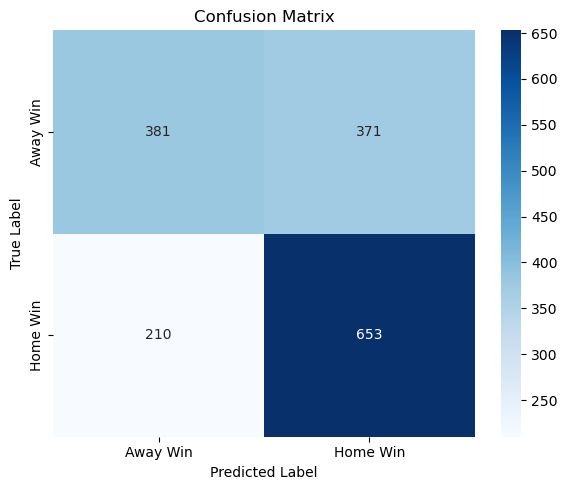

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

scaler = MinMaxScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Logistic Regression also gives probabilities for log loss
train_loss = log_loss(y_train, model.predict_proba(X_train))
test_loss = log_loss(y_test, model.predict_proba(X_test))

# Print metrics
print("Train Accuracy:", round(train_accuracy, 4))
print("Test Accuracy:", round(test_accuracy, 4))
print("Train F1 Score:", round(train_f1, 4))
print("Test F1 Score:", round(test_f1, 4))
print("Train Loss:", round(train_loss, 4))
print("Test Loss:", round(test_loss, 4))

print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
labels = ["Away Win", "Home Win"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


c:\Users\trito\anaconda3\envs\oracle-arena\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


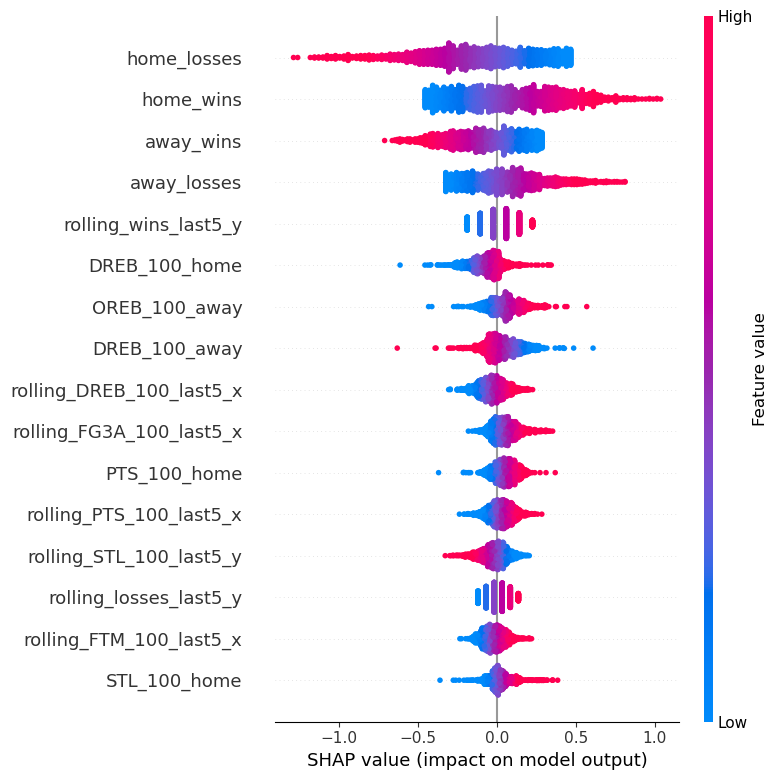

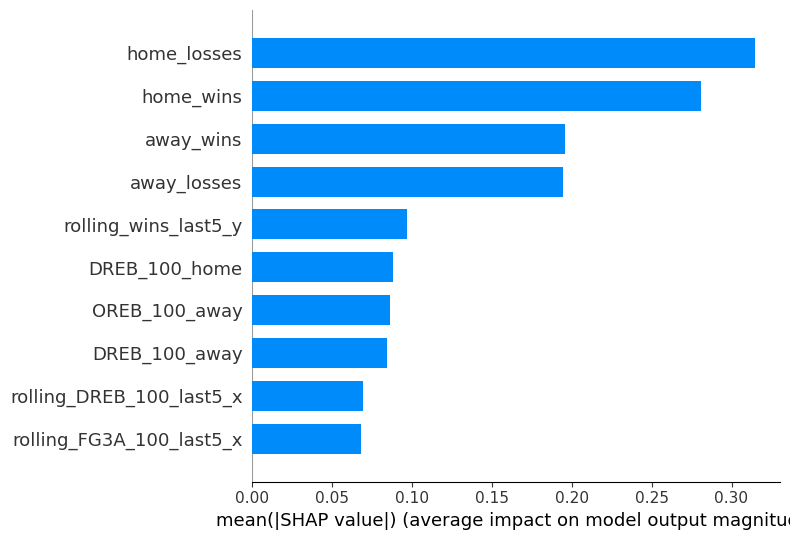

In [68]:
import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=16)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=10, plot_type="bar")

Epoch 1/100


c:\Users\trito\anaconda3\envs\oracle-arena\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5075 - loss: 0.9650 - val_accuracy: 0.6000 - val_loss: 0.6703 - learning_rate: 0.0010
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5496 - loss: 0.7670 - val_accuracy: 0.6260 - val_loss: 0.6482 - learning_rate: 0.0010
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5681 - loss: 0.7122 - val_accuracy: 0.6198 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5796 - loss: 0.6833 - val_accuracy: 0.6310 - val_loss: 0.6345 - learning_rate: 0.0010
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5976 - loss: 0.6660 - val_accuracy: 0.6285 - val_loss: 0.6301 - learning_rate: 0.0010
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6150 - loss: 0.6521 - val_accuracy: 0.6402 - val_loss: 0.6295 - learning_rate: 0.0010
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.6607 - val_a

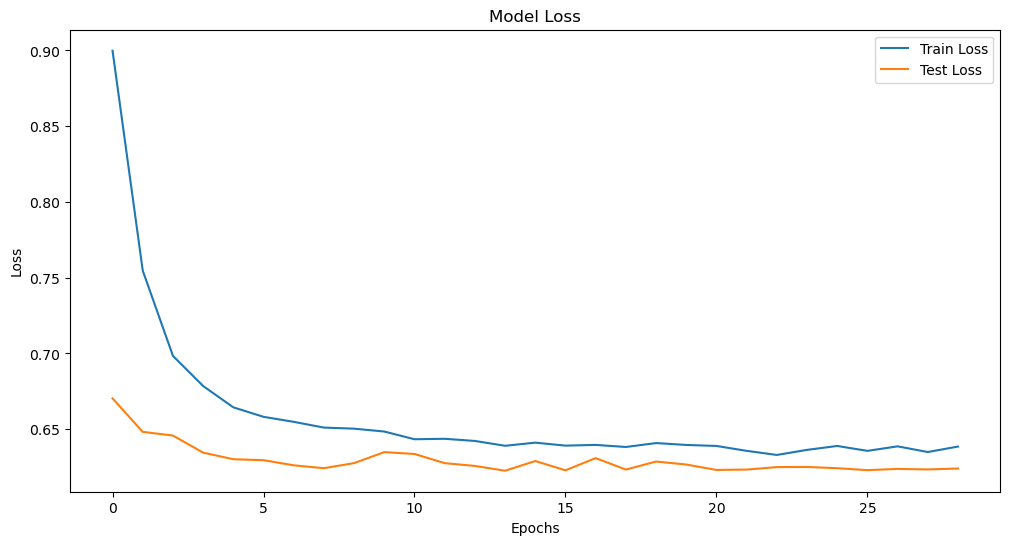

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Deep Feedforward Neural Network

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model = Sequential()

# First hidden layer
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second hidden layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Third hidden layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Fourth hidden layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Nadam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping, lr_scheduler])

train_accuracy = accuracy_score(y_train, (model.predict(X_train) > 0.5).astype(int))
test_accuracy = accuracy_score(y_test, (model.predict(X_test) > 0.5).astype(int))

train_f1 = f1_score(y_train, (model.predict(X_train) > 0.5).astype(int))
test_f1 = f1_score(y_test, (model.predict(X_test) > 0.5).astype(int))

print(f"Train Accuracy: {train_accuracy:.4f} | Train F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} | Test F1: {test_f1:.4f}")

# Plot the training history (loss/accuracy)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Accuracy: 0.6353
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.44      0.53       752
           1       0.62      0.81      0.70       863

    accuracy                           0.64      1615
   macro avg       0.64      0.62      0.62      1615
weighted avg       0.64      0.64      0.62      1615



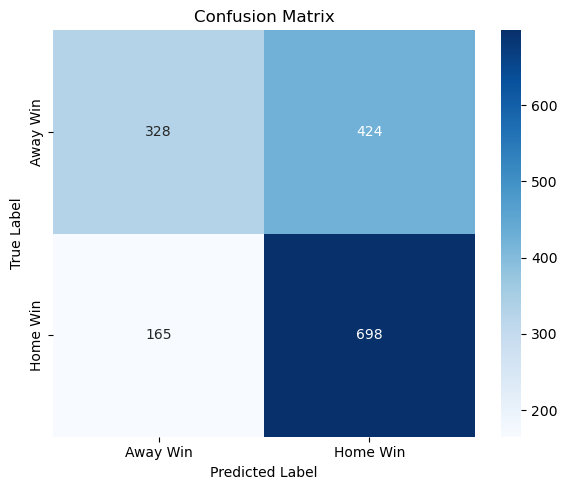

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb

# Step 1: Preprocessing
scaler = MinMaxScaler()

# Assume X and y are already defined
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Step 2: Initialize models
log_reg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

# Step 3: Create Voting Classifier (Hard Voting)
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf), ('xgb', xgb_model)],
    voting='soft'  # 'hard' voting means the predicted class is the one that gets the most votes
)

# Step 4: Train the ensemble model
voting_clf.fit(X_train, y_train)

# Step 5: Predictions and evaluation
y_pred = voting_clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["Away Win", "Home Win"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Accuracy: 0.6285
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50       752
           1       0.61      0.83      0.71       863

    accuracy                           0.63      1615
   macro avg       0.64      0.61      0.60      1615
weighted avg       0.64      0.63      0.61      1615



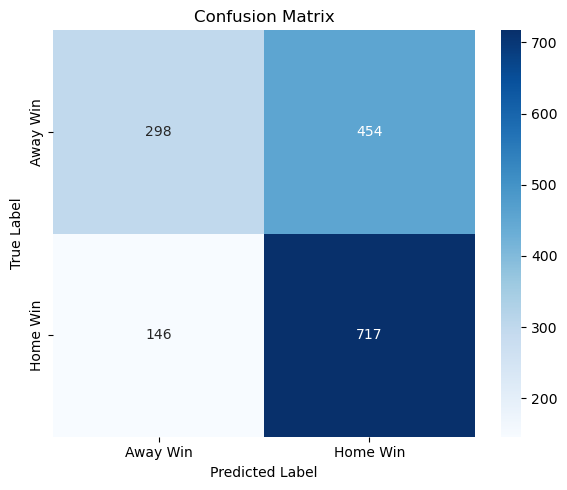

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestClassifier(
    max_depth = 26, 
    max_features = 'sqrt', 
    min_samples_leaf = 18, 
    min_samples_split = 13, 
    n_estimators = 211
)
# model = RandomForestClassifier(
#     n_estimators=211,      # number of trees
#     max_depth=100,          # limit depth to prevent overfitting
#     min_samples_split=5,   # minimum samples to split a node
#     min_samples_leaf=4,    # minimum samples per leaf
#     max_features='sqrt',   # number of features to consider when looking for best split
#     class_weight='balanced',  # handle imbalance
#     random_state=42,
#     n_jobs=-1
# )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ["Away Win", "Home Win"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(5, 30),         
    'min_samples_split': randint(2, 20),      
    'min_samples_leaf': randint(1, 20),     
    'max_features': ['sqrt', 'log2', None]   
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5, 
    verbose=1,
    random_state=42,
    n_jobs=1,                 
    scoring='accuracy'
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

c:\Users\trito\anaconda3\envs\oracle-arena\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:54:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


Train Accuracy: 0.6460 | Train Loss: 0.6353 | Train F1: 0.7236
Test Accuracy:  0.6328 | Test Loss:  0.6397 | Test F1:  0.7097

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.68      0.39      0.50       752
           1       0.61      0.84      0.71       863

    accuracy                           0.63      1615
   macro avg       0.65      0.62      0.61      1615
weighted avg       0.65      0.63      0.61      1615



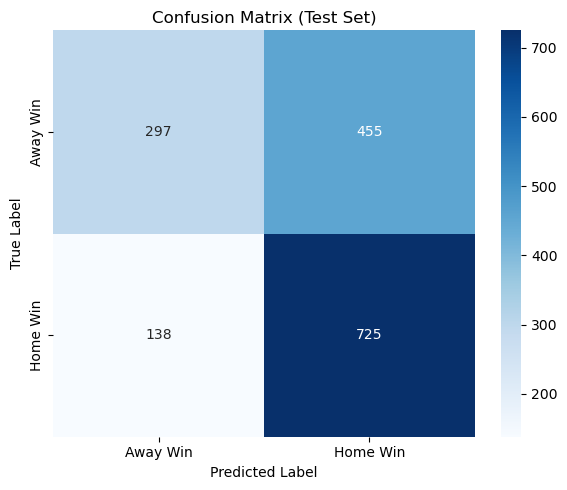

AttributeError: 'Booster' object has no attribute 'evals_result'

In [179]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix

# Split data (still no shuffle if you are respecting time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to DMatrix format, which is what xgboost expects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost model with better regularization
params = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'max_depth': 2,  
    'min_child_weight': 50,
    'gamma': 10,                
    'subsample': 0.6,             
    'colsample_bytree': 0.6,      
    'reg_alpha': 10,             
    'reg_lambda': 50,            
    'eval_metric': 'logloss',
    'objective': 'binary:logistic',  # Assuming binary classification
    'random_state': 42
}

# List of evaluation sets for early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]

# Train the model with early stopping
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

# Predict using the trained bst model
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

# Convert probabilities to binary labels (0 or 1)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Metrics
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
test_accuracy = accuracy_score(y_test, y_test_pred_binary)

train_f1 = f1_score(y_train, y_train_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)

train_loss = log_loss(y_train, y_train_pred)
test_loss = log_loss(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f} | Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f} | Test Loss:  {test_loss:.4f} | Test F1:  {test_f1:.4f}")

# Classification Report
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred_binary))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_binary)
labels = ["Away Win", "Home Win"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot training loss and validation loss
results = bst.evals_result()

epochs = len(results['train']['logloss'])
x_axis = range(epochs)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, results['train']['logloss'], label='Train')
plt.plot(x_axis, results['eval']['logloss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\trito\anaconda3\envs\oracle-arena\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:26:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.6217
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.44      0.52       752
           1       0.62      0.78      0.69       863

    accuracy                           0.62      1615
   macro avg       0.62      0.61      0.60      1615
weighted avg       0.62      0.62      0.61      1615



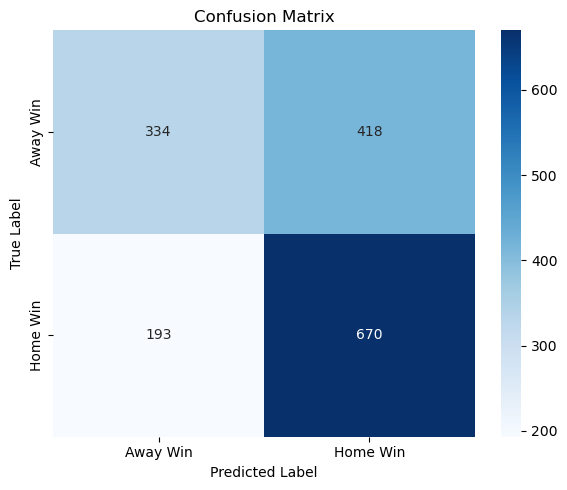

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=2,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 4))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = ["Away Win", "Home Win"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [31]:
# Imports
import pandas as pd
import numpy as np
import json

In [32]:
# Load datasets
games = pd.read_csv("games-full.csv", dtype={'game_id': str})
player_stats = pd.read_csv("player_game_stats-full-fixed.csv", dtype={'game_id': str})

# Filter regular season games
games = games[games["game_id"].str.startswith("002")]
player_stats = player_stats[player_stats["game_id"].str.startswith("002")]

In [33]:
# Melt games to count games played per team
games_melted = games.melt(
    id_vars=["game_id", "season_year"],
    value_vars=["home_team_id", "away_team_id"],
    value_name="team_id"
)

games_played = games_melted.groupby(["season_year", "team_id"])["game_id"].nunique().reset_index()
games_played.rename(columns={"game_id": "games_played"}, inplace=True)

# Parse nested player stats
player_stats['player_game_stats'] = player_stats['player_game_stats'].apply(json.loads)
player_stats.dropna(subset=['player_game_stats'], inplace=True)

player_stats = pd.concat([
    player_stats.drop(columns=['player_game_stats']),
    player_stats['player_game_stats'].apply(pd.Series)
], axis=1)

# Merge season year
player_stats = player_stats.merge(games[['game_id', 'season_year']], on='game_id', how='left')


In [44]:
# Stat columns to track
stats_columns = [
    'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 
    'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PTS'
]

# Sum stats per game/team
team_stats = player_stats[['season_year', 'game_id', 'team_id'] + stats_columns]
team_stats = team_stats.groupby(['game_id', 'team_id'])[stats_columns].sum().reset_index()

# Merge with game info
team_stats = team_stats.merge(
    games[['game_id', 'season_year', 'home_team_id', 'away_team_id']],
    on='game_id', how='left'
)


In [45]:
# Separate home and away stats
home_stats = team_stats[team_stats['team_id'] == team_stats['home_team_id']]
away_stats = team_stats[team_stats['team_id'] == team_stats['away_team_id']]

home_stats = home_stats.rename(columns={col: f"{col}_home" for col in stats_columns}).drop(columns=["team_id"])
away_stats = away_stats.rename(columns={col: f"{col}_away" for col in stats_columns}).drop(columns=["team_id"])

# Combine home and away stats into one row per game
game_stats = home_stats.merge(away_stats, on=["game_id", "season_year", "home_team_id", "away_team_id"], how="inner")

# Determine game outcome
game_stats["home_team_win"] = (game_stats["PTS_home"] > game_stats["PTS_away"]).astype(int)

# Winner lookup table
winners = pd.DataFrame({
    "game_id": game_stats["game_id"],
    "winner_team_id": np.where(game_stats["home_team_win"] == 1, game_stats["home_team_id"], game_stats["away_team_id"])
})


In [46]:
# Long format for team-game stats
home_team_stats = game_stats[["game_id", "season_year", "home_team_id"] + [col for col in game_stats.columns if col.endswith("_home")]].copy()
away_team_stats = game_stats[["game_id", "season_year", "away_team_id"] + [col for col in game_stats.columns if col.endswith("_away")]].copy()

home_team_stats.columns = ["game_id", "season_year", "team_id"] + [col.replace("_home", "") for col in home_team_stats.columns[3:]]
away_team_stats.columns = ["game_id", "season_year", "team_id"] + [col.replace("_away", "") for col in away_team_stats.columns[3:]]

long_stats = pd.concat([home_team_stats, away_team_stats]).sort_values(["team_id", "season_year", "game_id"])

# Merge game date
long_stats = long_stats.merge(games[['game_id', 'game_date']], on='game_id', how='left').sort_values('game_date').reset_index(drop=True)


In [47]:
# Merge winners
wl_count = long_stats.merge(winners, on="game_id", how="left")

# Add win/loss tracking
wl_count["won_game"] = (wl_count["team_id"] == wl_count["winner_team_id"]).astype(int)
wl_count["games_so_far"] = wl_count.groupby(["team_id", "season_year"]).cumcount()
wl_count["wins"] = wl_count.groupby(["team_id", "season_year"])["won_game"].cumsum() - wl_count["won_game"]
wl_count["losses"] = (wl_count["games_so_far"] - wl_count["wins"]).clip(lower=0)


In [48]:
# Compute possessions
long_stats["POSS"] = (long_stats["FGA"] + 0.44 * long_stats["FTA"] - long_stats["OREB"] + long_stats["TO"]).clip(lower=0)

# Per 100 possession stats
per_100_columns = []
for stat in stats_columns:
    col_name = f"{stat}_100"
    long_stats[col_name] = 100 * long_stats[stat] / long_stats["POSS"]
    per_100_columns.append(col_name)

# Add possessions
per_100_columns.append("POSS")


In [49]:
# Expanding mean (rolling avg across all games)
long_stats_avg = long_stats.copy()
long_stats_avg[per_100_columns] = long_stats.groupby(["team_id", "season_year"], group_keys=False)[per_100_columns].apply(lambda g: g.shift().expanding().mean())

# Shift season for fallback values
def shift_season(season_year):
    start, end = season_year.split("-")
    return f"{int(start)+1}-{str(int(end)+1).zfill(2)}"

prev_season_averages = long_stats.groupby(["team_id", "season_year"])[per_100_columns].mean().reset_index()
prev_season_averages["season_year"] = prev_season_averages["season_year"].apply(shift_season)

long_stats_avg = long_stats_avg.merge(prev_season_averages, on=["team_id", "season_year"], how="left", suffixes=("", "_fallback"))

for stat in per_100_columns:
    long_stats_avg[stat] = long_stats_avg[stat].fillna(long_stats_avg[f"{stat}_fallback"])
    long_stats_avg.drop(columns=[f"{stat}_fallback"], inplace=True)

long_stats_avg.dropna(inplace=True)


In [50]:
# Merge for rolling
last_5_games = long_stats.merge(wl_count[["game_id", "team_id", "wins", "losses", "won_game"]], on=["game_id", "team_id"], how="left")

# Rolling 5-game means and win/loss counts
rolling_means = last_5_games.groupby(["team_id", "season_year"])[per_100_columns].transform(lambda x: x.shift(1).rolling(5, min_periods=5).mean())
rolling_wins = last_5_games.groupby(["team_id", "season_year"])["won_game"].transform(lambda x: x.shift(1).rolling(5, min_periods=5).sum())
rolling_losses = last_5_games.groupby(["team_id", "season_year"])["won_game"].transform(lambda x: (1 - x.shift(1)).rolling(5, min_periods=5).sum())

# Add rolling features
rolling_5 = pd.concat([
    rolling_means.rename(columns={col: f"rolling_{col}_last5" for col in rolling_means.columns}),
    rolling_wins.rename("rolling_wins_last5"),
    rolling_losses.rename("rolling_losses_last5")
], axis=1)

last_5_games = pd.concat([last_5_games, rolling_5], axis=1)

# Full Season Averages + Fallback (for last 5 games)
# Expanding mean (rolling avg across all games)
last_5_games_avg = last_5_games.copy()
last_5_games_avg[per_100_columns] = last_5_games.groupby(["team_id", "season_year"], group_keys=False)[per_100_columns].apply(lambda g: g.shift().expanding().mean())

# Fallback for rolling stats if there are not enough games
last_5_games_avg = last_5_games_avg.merge(prev_season_averages, on=["team_id", "season_year"], how="left", suffixes=("", "_fallback"))

for stat in per_100_columns:
    last_5_games_avg[stat] = last_5_games_avg[stat].fillna(last_5_games_avg[f"{stat}_fallback"])
    last_5_games_avg.drop(columns=[f"{stat}_fallback"], inplace=True)

last_5_games_avg.dropna(inplace=True)


In [51]:
# Opponent stats
opponent_stats = long_stats[["game_id", "team_id"] + per_100_columns].rename(
    columns={col: col + "_opp" for col in per_100_columns} | {"team_id": "team_id_opp"}
)

# Join to get opponent stats per team
team_opponent_stats = long_stats[["game_id", "team_id", "season_year"]].merge(opponent_stats, on="game_id")
team_opponent_stats = team_opponent_stats[team_opponent_stats["team_id"] != team_opponent_stats["team_id_opp"]]

# Expanding mean for opponent allowed stats
opp_stat_cols = [col + "_opp" for col in per_100_columns]
team_opponent_stats_avg = team_opponent_stats.copy()
team_opponent_stats_avg[opp_stat_cols] = team_opponent_stats.groupby(["team_id", "season_year"], group_keys=False)[opp_stat_cols].apply(lambda g: g.shift().expanding().mean())

# Fallback
prev_opp_season_averages = team_opponent_stats.groupby(["team_id", "season_year"])[opp_stat_cols].mean().reset_index()
prev_opp_season_averages["season_year"] = prev_opp_season_averages["season_year"].apply(shift_season)

team_opponent_stats_avg = team_opponent_stats_avg.merge(prev_opp_season_averages, on=["team_id", "season_year"], how="left", suffixes=("", "_fallback"))

for stat in opp_stat_cols:
    team_opponent_stats_avg[stat] = team_opponent_stats_avg[stat].fillna(team_opponent_stats_avg[f"{stat}_fallback"])
    team_opponent_stats_avg.drop(columns=[f"{stat}_fallback"], inplace=True)

team_opponent_stats_avg.dropna(inplace=True)


In [52]:
# Pull rolling 5 games
rolling_cols = ["game_id", "team_id"] + [col for col in last_5_games.columns if col.startswith("rolling_")]
rolling_features_df = last_5_games[rolling_cols]

# Merge all
long_stats_avg = long_stats_avg.merge(rolling_features_df, on=["game_id", "team_id"], how="left")

# Separate home and away
home_features = long_stats_avg.merge(game_stats[['game_id', 'home_team_id']], left_on=["game_id", "team_id"], right_on=["game_id", "home_team_id"], how="inner").drop(columns=["home_team_id"])
away_features = long_stats_avg.merge(game_stats[['game_id', 'away_team_id']], left_on=["game_id", "team_id"], right_on=["game_id", "away_team_id"], how="inner").drop(columns=["away_team_id"])

# Merge wins/losses
home_features = home_features.merge(wl_count[['game_id', 'team_id', 'wins', 'losses']], on=["game_id", "team_id"], how="left")
away_features = away_features.merge(wl_count[['game_id', 'team_id', 'wins', 'losses']], on=["game_id", "team_id"], how="left")

# Rename columns
home_features = home_features.rename(columns={stat: f"{stat}_home" for stat in per_100_columns} | {"wins": "home_wins", "losses": "home_losses"})
away_features = away_features.rename(columns={stat: f"{stat}_away" for stat in per_100_columns} | {"wins": "away_wins", "losses": "away_losses"})


In [53]:
# Merge final ML DataFrame
ml_df = home_features.merge(away_features, on=["game_id", "game_date"], how="inner").merge(
    game_stats[["game_id", "home_team_win"]], on="game_id", how="inner"
).drop_duplicates("game_id")

# Drop irrelevant columns
ml_df = ml_df.drop(columns=["team_id_x", "team_id_y", "season_year_x", "season_year_y", "game_date"], errors="ignore")

# Features and Target
X = ml_df.drop(columns=["game_id", "home_team_win"])
y = ml_df["home_team_win"]

# Save
ml_df.to_csv("ml_features.csv", index=False)
X.to_csv("X_features.csv", index=False)
y.to_csv("y_target.csv", index=False)

X.head(), y.head()


(   FGM_x  FGA_x  FG3M_x  FG3A_x  FTM_x  FTA_x  OREB_x  DREB_x  AST_x  STL_x  \
 0   37.0   75.0    12.0    30.0   21.0   24.0    12.0    43.0   22.0    2.0   
 1   56.0   95.0    16.0    31.0   21.0   33.0    12.0    40.0   35.0    6.0   
 2   36.0   94.0     6.0    31.0   10.0   14.0    12.0    32.0   18.0    8.0   
 3   44.0   93.0    17.0    46.0   13.0   21.0    11.0    39.0   27.0    9.0   
 4   43.0   92.0    13.0    35.0   14.0   19.0    12.0    37.0   24.0    3.0   
 
    ...  rolling_AST_100_last5_y  rolling_STL_100_last5_y  \
 0  ...                      NaN                      NaN   
 1  ...                      NaN                      NaN   
 2  ...                      NaN                      NaN   
 3  ...                      NaN                      NaN   
 4  ...                      NaN                      NaN   
 
    rolling_BLK_100_last5_y  rolling_TO_100_last5_y  rolling_PTS_100_last5_y  \
 0                      NaN                     NaN                   